# A Single-Cell and Spatial Map of the Colorectal Epithelium in Health and Gastrointestinal Disorders

This notebook contains preprocessing steps and figure generation code associated with the analyses presented in the paper. The goal is to ensure transparency and reproducibility by documenting key data handling, integration, and visualization steps for the spatial transcriptomics data.

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import scipy
import matplotlib_scalebar
# import popv
import os

print("scanpy: Version ", sc.__version__)
print("anndata: Version ", ad.__version__)
print("pandas: Version ", pd.__version__)
print("numpy: Version ", np.__version__)
print("scikit-learn: Version ", sklearn.__version__)
print("scipy: Version ", scipy.__version__)
print("matplotlib: Version ", matplotlib.__version__)
print("matplotlib-scalebar: Version ", matplotlib_scalebar.__version__)
# print("popv: Version ", popv.__version__)

scanpy: Version  1.9.6
anndata: Version  0.10.3
pandas: Version  2.2.0
numpy: Version  1.23.4
scikit-learn: Version  1.4.1.post1
scipy: Version  1.9.1
matplotlib: Version  3.5.3
matplotlib-scalebar: Version  0.8.1


In [6]:
sc_colon = sc.read_h5ad('CD_and_HV_Colon_only.h5ad')
sc_rectum = sc.read_h5ad('IBS_and_HV_rectum_only.h5ad')
sc_healthy = sc.read_h5ad('HV_only_Colon_and_rectum.h5ad')

In [2]:
sc_healthy = sc.read_h5ad('/mnt/data/tool/merscope_helmsley/Elodie_Alexandre_rds/HV_only_Colon_and_rectum.h5ad')
sc_colon = sc.read_h5ad('/mnt/data/tool/merscope_helmsley/Elodie_Alexandre_rds/CD_and_HV_Colon_only.h5ad')
sc_rectum = sc.read_h5ad('/mnt/data/tool/merscope_helmsley/Elodie_Alexandre_rds/IBS_and_HV_rectum_only.h5ad')

/mnt/data/miniconda3/envs/Tangram_squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1252: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


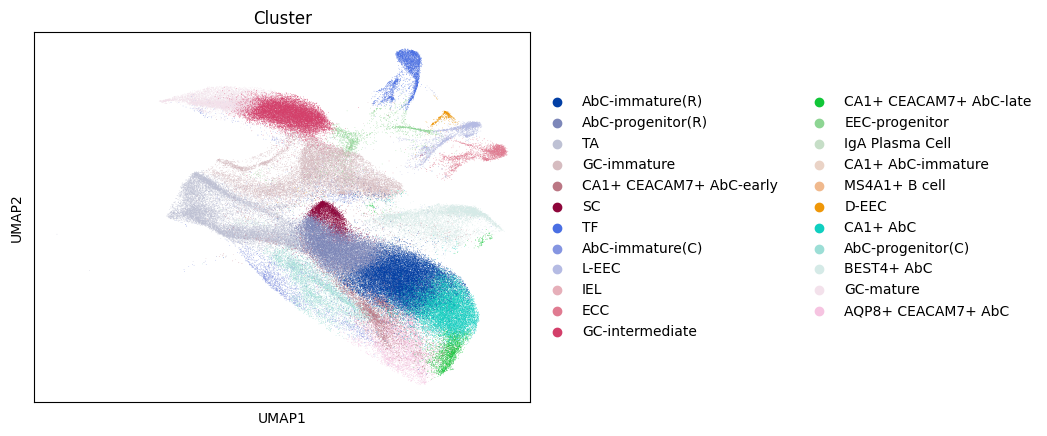

/mnt/data/miniconda3/envs/Tangram_squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1252: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


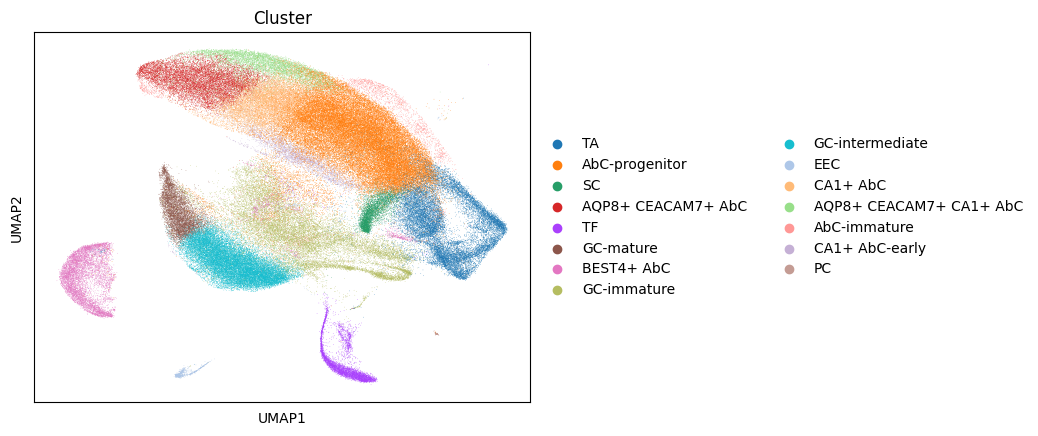

/mnt/data/miniconda3/envs/Tangram_squidpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1252: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


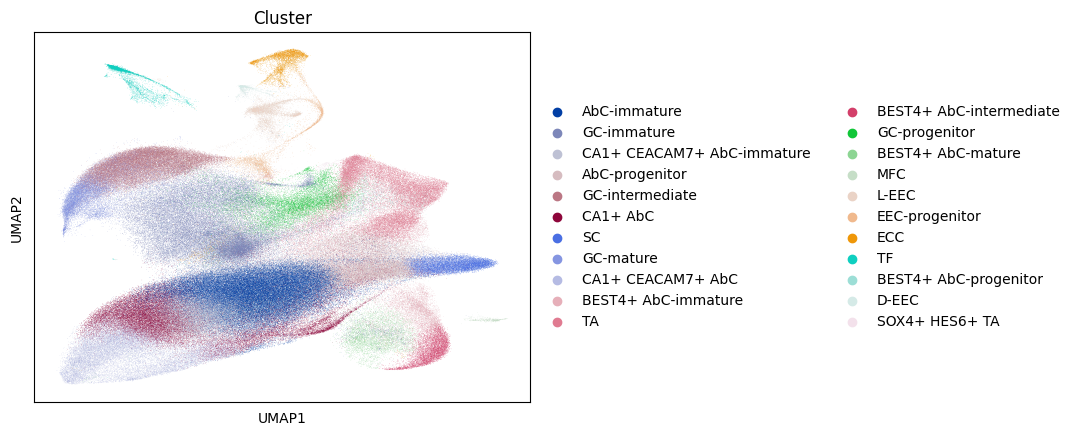

In [3]:
sc.pl.umap(sc_healthy,color='Cluster')
sc.pl.umap(sc_colon,color='Cluster')
sc.pl.umap(sc_rectum,color='Cluster')

## Loading and Preprocessing Xenium Spatial Datasets

In this section, we load spatial transcriptomics data generated with 10x Genomics Xenium. Each sample is organized under a unique directory structure containing a `cell_feature_matrix.h5` file and a corresponding `cells.csv.gz` metadata file. For each dataset:

- We load the expression matrix using `scanpy.read_10x_h5`
- Attach spatial coordinates and metadata from the `.csv`
- Tag each dataset with its associated PIN

We also collect metrics for each dataset from `metrics_summary.csv`.

Additionally, a list of incorrectly labeled PINs was corrected using a mapping between `wrongPIN` and `correctPIN`, which is stored in the `.obs` attribute of each AnnData object.


In [4]:
base = "/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/"
adata_list_xenium = []
metrics_list = []

for top_folder in sorted(os.listdir(base)):
    top_folder_path = os.path.join(base, top_folder)
    if os.path.isdir(top_folder_path):
        output_folders = sorted([folder for folder in os.listdir(top_folder_path) if folder.startswith("output-")])
        for output_folder in output_folders:
            output_folder_path = os.path.join(top_folder_path, output_folder)
            h5_file_path = os.path.join(output_folder_path,"cell_feature_matrix.h5")
            csv_file_path = os.path.join(output_folder_path, "cells.csv.gz")
            pin_number = output_folder_path.split("__")[4]
            print(output_folder_path)
            adata = sc.read_10x_h5(filename=h5_file_path)
            df = pd.read_csv(csv_file_path)
            df.set_index(adata.obs_names, inplace=True)
            adata.obs = df.copy()
            adata.obs['PIN'] = pin_number
            adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].to_numpy()
            adata_list_xenium.append(adata)
            metrics=pd.read_csv(os.path.join(output_folder_path,'metrics_summary.csv'))
            metrics_list.append(metrics)
            
metrics_df = pd.concat(metrics_list)

/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/20231003__161034__HELMSLEY_PILOT/output-XETG00075__0010695__PIN1274_1__20231003__161144
/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/20231003__161034__HELMSLEY_PILOT/output-XETG00075__0010695__PIN1274_2__20231003__161144
/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/20231003__161034__HELMSLEY_PILOT/output-XETG00075__0010695__PIN1337_1__20231003__161144
/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/20231003__161034__HELMSLEY_PILOT/output-XETG00075__0010695__PIN1337_2__20231003__161144
/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/20231003__161034__HELMSLEY_PILOT/output-XETG00075__0010773__PIN1456_1__20231003__161144
/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/20231003__161034__HELMSLEY_PILOT/output-XETG00075__0010773__PIN1456_2__20231003__161144
/mnt/Vol1/Xenium/Academic/HelmsleyAlexanderDeSouza/20231003__161034__HELMSLEY_PILOT/output-XETG00075__0010773__PIN1489_1__20231003__161144
/mnt/Vol1/Xenium/Academic/H

adjusted_negative_control_probe_rate    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

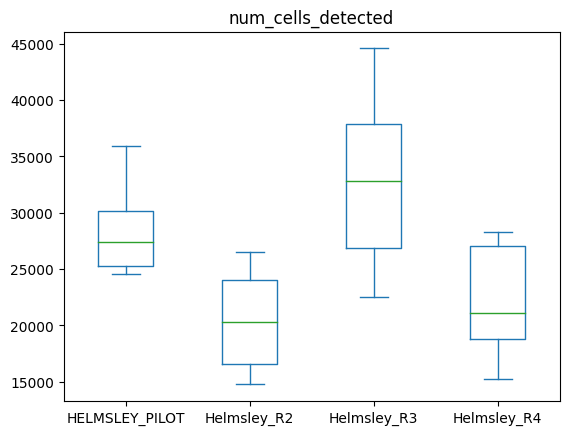

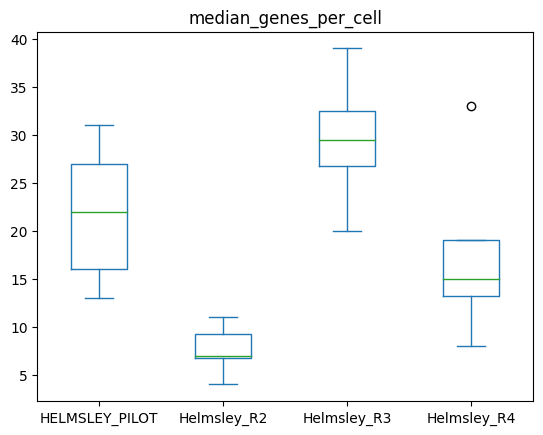

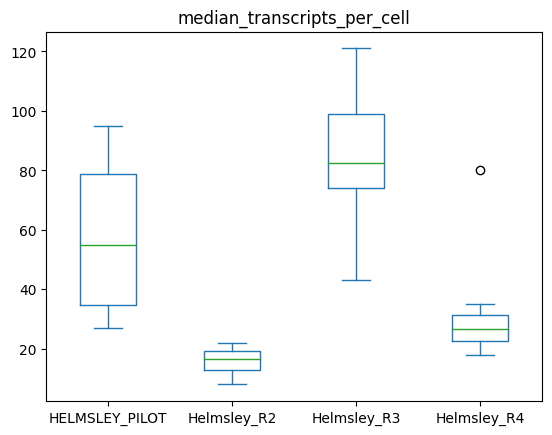

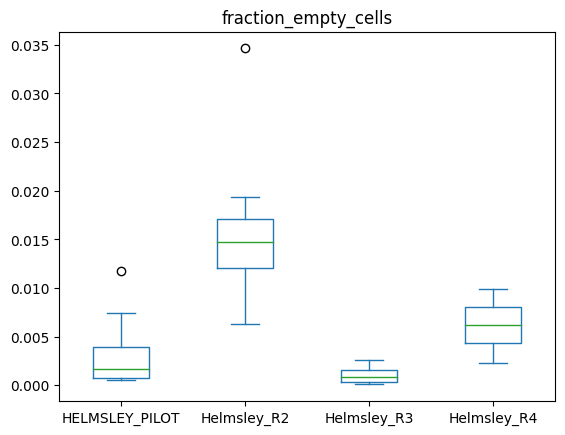

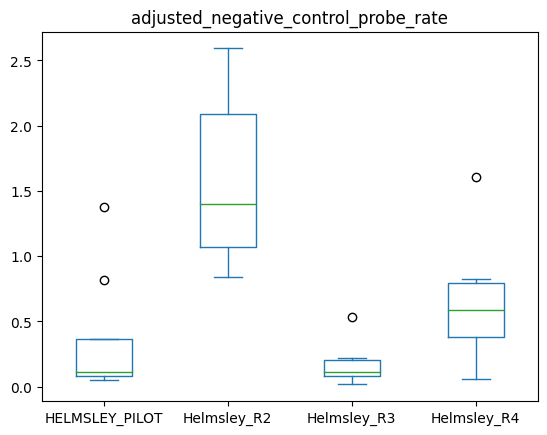

In [28]:
metrics_df.plot.box(by='run_name',column='num_cells_detected')
metrics_df.plot.box(by='run_name',column='median_genes_per_cell')
metrics_df.plot.box(by='run_name',column='median_transcripts_per_cell')
metrics_df.plot.box(by='run_name',column='fraction_empty_cells')
metrics_df.plot.box(by='run_name',column='adjusted_negative_control_probe_rate')

In [5]:
# Define wrong and correct PIN lists
Wronglist = [
    "PIN1274_1", "PIN1274_2", "PIN1337_1", "PIN1337_2", "PIN1456_1", "PIN1456_2",
    "PIN1489_1", "PIN1489_2", "PIN1358", "PIN1363", "PIN1457_1", "PIN1457_2",
    "PIN1328", "PIN1385", "PIN1440", "PIN1733", "PIN1067", "PIN1340", "PIN1479",
    "PIN1540", "PIN1427", "PIN1458", "PIN1487", "PIN1491", "PIN1588", "PIN1595",
    "PIN1812", "PIN1855", "PIN1526", "PIN1565", "PIN1591", "PIN1639"
]

Correct_list = [
    "PIN1337_1", "PIN1337_2", "PIN1274_1", "PIN1274_2", "PIN1489_1", "PIN1489_2",
    "PIN1456_1", "PIN1456_2", "PIN1363", "PIN1358", "PIN1457_1", "PIN1457_2",
    "PIN1440", "PIN1733", "PIN1328", "PIN1385", "PIN1340", "PIN1067", "PIN1540",
    "PIN1479", "PIN1491", "PIN1487", "PIN1458", "PIN1427", "PIN1588", "PIN1595",
    "PIN1812", "PIN1855", "PIN1526", "PIN1565", "PIN1591", "PIN1639"
]

# Create a mapping dictionary for replacement
pin_mapping = dict(zip(Wronglist, Correct_list))

# Function to rename 'PIN' to 'wrongPIN' and add 'correctPIN'
def fix_pin_names(adata):
    """
    Renames the 'PIN' column to 'wrongPIN' and adds 'correctPIN' with corrected values.

    Parameters:
    - adata: AnnData object
    
    Returns:
    - Updated AnnData object with corrected PIN values.
    """
    if "PIN" not in adata.obs.columns:
        print("Warning: 'PIN' column not found in AnnData object. Skipping.")
        return adata
    
    # Rename existing 'PIN' column to 'wrongPIN'
    adata.obs.rename(columns={"PIN": "wrongPIN"}, inplace=True)
    
    # Map wrong PINs to correct PINs
    adata.obs["correctPIN"] = adata.obs["wrongPIN"].map(pin_mapping)
    
    # Print how many PINs were corrected
    num_corrected = adata.obs["correctPIN"].notna().sum()
    print(f"Corrected {num_corrected} PIN values.")

    return adata

# Apply to all AnnData objects in the list
adata_list_xenium = [fix_pin_names(adata) for adata in adata_list_xenium]


Corrected 29490 PIN values.
Corrected 28410 PIN values.
Corrected 26296 PIN values.
Corrected 25269 PIN values.
Corrected 35915 PIN values.
Corrected 32195 PIN values.
Corrected 25187 PIN values.
Corrected 24523 PIN values.
Corrected 16687 PIN values.
Corrected 16154 PIN values.
Corrected 26285 PIN values.
Corrected 23244 PIN values.
Corrected 22044 PIN values.
Corrected 18590 PIN values.
Corrected 26484 PIN values.
Corrected 14753 PIN values.
Corrected 44591 PIN values.
Corrected 25966 PIN values.
Corrected 29981 PIN values.
Corrected 27100 PIN values.
Corrected 36421 PIN values.
Corrected 22480 PIN values.
Corrected 42260 PIN values.
Corrected 35634 PIN values.
Corrected 19294 PIN values.
Corrected 26978 PIN values.
Corrected 28244 PIN values.
Corrected 20538 PIN values.
Corrected 21633 PIN values.
Corrected 27041 PIN values.
Corrected 17327 PIN values.
Corrected 15268 PIN values.


In [12]:
def annotate_spatial_metadata(adata_list):
    for i, adata in enumerate(adata_list):
        adata.obs_names_make_unique()
        adata.obs['Slide'] = f'slide{i}'
        
        if i in range(0, 8):
            adata.obs['tissue'] = 'Rectum'
            adata.obs['condition'] = 'Healthy-Rectum'
            adata.obs['runnumber'] = 'Run1'
        
        elif i in range(8, 16):
            adata.obs['tissue'] = 'Colon'
            adata.obs['condition'] = 'Healthy-Colon'
            adata.obs['runnumber'] = 'Run2'
        
        elif i in [16,17,18,19,21,23]:
            adata.obs['tissue'] = 'Rectum'
            adata.obs['condition'] = 'IBS-D-Rectum'
            adata.obs['runnumber'] = 'Run3'
        
        elif i in [20,22]:
            adata.obs['tissue'] = 'Rectum'
            adata.obs['condition'] = 'IBS-C-Rectum'
            adata.obs['runnumber'] = 'Run3'
        
        elif i in range(24, 28):
            adata.obs['tissue'] = 'Colon'
            adata.obs['condition'] = 'CD-IBS-Colon'
            adata.obs['runnumber'] = 'Run4'
        
        elif i in range(28, 32):
            adata.obs['tissue'] = 'Colon'
            adata.obs['condition'] = 'CD+IBS-Colon'
            adata.obs['runnumber'] = 'Run4'
        
        # Print sample summary for verification
        print(f"Slide {i}: {adata.obs['condition'].unique()[0]}, Correct PINs: {list(adata.obs['correctPIN'].unique())}")

def preprocess_single_samples(adata_list):
    for i, adata in enumerate(adata_list):
        adata.obs_names_make_unique()
        sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=[20], log1p=True)
        sc.pp.filter_cells(adata, min_counts=30)
        adata.layers['rawcounts'] = adata.X
        counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
        adata.layers['log1p_norm'] = sc.pp.log1p(counts['X'], copy=True)


In [13]:
annotate_spatial_metadata(adata_list_xenium)
preprocess_single_samples(adata_list_xenium)

Slide 0: Healthy-Rectum, Correct PINs: ['PIN1337_1']
Slide 1: Healthy-Rectum, Correct PINs: ['PIN1337_2']
Slide 2: Healthy-Rectum, Correct PINs: ['PIN1274_1']
Slide 3: Healthy-Rectum, Correct PINs: ['PIN1274_2']
Slide 4: Healthy-Rectum, Correct PINs: ['PIN1489_1']
Slide 5: Healthy-Rectum, Correct PINs: ['PIN1489_2']
Slide 6: Healthy-Rectum, Correct PINs: ['PIN1456_1']
Slide 7: Healthy-Rectum, Correct PINs: ['PIN1456_2']
Slide 8: Healthy-Colon, Correct PINs: ['PIN1363']
Slide 9: Healthy-Colon, Correct PINs: ['PIN1358']
Slide 10: Healthy-Colon, Correct PINs: ['PIN1457_1']
Slide 11: Healthy-Colon, Correct PINs: ['PIN1457_2']
Slide 12: Healthy-Colon, Correct PINs: ['PIN1440']
Slide 13: Healthy-Colon, Correct PINs: ['PIN1733']
Slide 14: Healthy-Colon, Correct PINs: ['PIN1328']
Slide 15: Healthy-Colon, Correct PINs: ['PIN1385']
Slide 16: IBS-D-Rectum, Correct PINs: ['PIN1340']
Slide 17: IBS-D-Rectum, Correct PINs: ['PIN1067']
Slide 18: IBS-D-Rectum, Correct PINs: ['PIN1540']
Slide 19: IBS-D-

In [15]:
spatial_colon = []
spatial_rectum = []
for adata in adata_list_xenium:
    if adata.obs['tissue'].unique()=='Colon':
        spatial_colon.append(adata)
    else:
        spatial_rectum.append(adata)
        
merged_spatial_colon = ad.concat(spatial_colon,join='outer', axis=0)
merged_spatial_rectum = ad.concat(spatial_rectum,join='outer', axis=0)
merged_spatial_rectum = merged_spatial_rectum[~merged_spatial_rectum.obs['correctPIN'].isin(['PIN1427'])]

/mnt/data/miniconda3/envs/Tangram_squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/mnt/data/miniconda3/envs/Tangram_squidpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
for i in merged_spatial_rectum.obs['Slide'].unique():
    temp = merged_spatial_rectum[merged_spatial_rectum.obs['Slide']==i]
    print(i,list(temp.obs['correctPIN'].unique()),list(temp.obs['condition'].unique()))

slide0 ['PIN1337_1'] ['Healthy-Rectum']
slide1 ['PIN1337_2'] ['Healthy-Rectum']
slide2 ['PIN1274_1'] ['Healthy-Rectum']
slide3 ['PIN1274_2'] ['Healthy-Rectum']
slide4 ['PIN1489_1'] ['Healthy-Rectum']
slide5 ['PIN1489_2'] ['Healthy-Rectum']
slide6 ['PIN1456_1'] ['Healthy-Rectum']
slide7 ['PIN1456_2'] ['Healthy-Rectum']
slide16 ['PIN1340'] ['IBS-D-Rectum']
slide17 ['PIN1067'] ['IBS-D-Rectum']
slide18 ['PIN1540'] ['IBS-D-Rectum']
slide19 ['PIN1479'] ['IBS-D-Rectum']
slide20 ['PIN1491'] ['IBS-C-Rectum']
slide21 ['PIN1487'] ['IBS-D-Rectum']
slide22 ['PIN1458'] ['IBS-C-Rectum']


In [26]:
for i in merged_spatial_colon.obs['Slide'].unique():
    temp = merged_spatial_colon[merged_spatial_colon.obs['Slide']==i]
    print(i,list(temp.obs['correctPIN'].unique()),list(temp.obs['condition'].unique()))

slide8 ['PIN1363'] ['Healthy-Colon']
slide9 ['PIN1358'] ['Healthy-Colon']
slide10 ['PIN1457_1'] ['Healthy-Colon']
slide11 ['PIN1457_2'] ['Healthy-Colon']
slide12 ['PIN1440'] ['Healthy-Colon']
slide13 ['PIN1733'] ['Healthy-Colon']
slide14 ['PIN1328'] ['Healthy-Colon']
slide15 ['PIN1385'] ['Healthy-Colon']
slide24 ['PIN1588'] ['CD-IBS-Colon']
slide25 ['PIN1595'] ['CD-IBS-Colon']
slide26 ['PIN1812'] ['CD-IBS-Colon']
slide27 ['PIN1855'] ['CD-IBS-Colon']
slide28 ['PIN1526'] ['CD+IBS-Colon']
slide29 ['PIN1565'] ['CD+IBS-Colon']
slide30 ['PIN1591'] ['CD+IBS-Colon']
slide31 ['PIN1639'] ['CD+IBS-Colon']


In [ ]:
merged_spatial_colon.write_h5ad('/mnt/data/tool/merscope_helmsley/xenium/merged_spatial_colon.h5ad')
merged_spatial_rectum.write_h5ad('/mnt/data/tool/merscope_helmsley/xenium/merged_spatial_rectum.h5ad')